# Song Twenty-One: To Listen or Not to Listen, That is the Data-Driven Decision

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from itertools import product
import pandas as pd
import scipy.special as spsp
import scipy.stats as spst
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols, poisson, negativebinomial, logit, mnlogit
from statsmodels.base.model import GenericLikelihoodModel

# Dataset: The Spotify Hit Predictor Dataset (1960-2019)
For my project, I have chosen **The Spotify Hit Predictor Dataset (1960-2019)**, a dataset of 41106 songs and their audio features from Spotify's API ranging from 1960 to 2019 (across six decades). These audio features are very informative and range from danceability to key. **Each song has a corresponding energy value between 0 and 1, that represents a perceptual measure of intensity and activity**


In [2]:
# Constructing the 40000+ song dataset, by joining songs across all csv files per decade
pre = "dataset-of-"
post = "0s.csv"
decs = ["0", "1", "6", "7", "8", "9"]
song_datasets = [pre+d+post for d in decs]
large_df = []
for ds in song_datasets:
    df = pd.read_csv(ds)
    yr = ds.split("-")[-1].split(".")[0][:-1]
    dec = "19" + yr if int(yr[0]) > 5 else "20" + yr
    df['year'] = [int(dec)]*df.shape[0]
    large_df.append(df)
songs_df = pd.concat(large_df)
print(songs_df.shape)

(41106, 20)


In [3]:
songs_df

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,year
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.000000,0.1590,0.532,133.061,196707,4,30.88059,13,1,2000
1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.000000,0.1480,0.688,92.988,242587,4,41.51106,10,1,2000
2,Clouds Of Dementia,Candlemass,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.004570,0.1740,0.300,86.964,338893,4,65.32887,13,0,2000
3,"Heavy Metal, Raise Hell!",Zwartketterij,spotify:track:2IjBPp2vMeX7LggzRN3iSX,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.078400,0.1920,0.333,148.440,255667,4,58.59528,9,0,2000
4,I Got A Feelin',Billy Currington,spotify:track:1tF370eYXUcWwkIvaq3IGz,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.000000,0.1250,0.631,112.098,193760,4,22.62384,10,1,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5515,(You're A) Go Nowhere,Reagan Youth,spotify:track:4e86fqSFhqRQk3Z9hm7XHt,0.396,0.795,9,-6.070,0,0.2340,0.000928,0.000209,0.1820,0.762,152.943,82107,4,30.34109,6,0,1990
5516,La Fiebre de Norma,La Castañeda,spotify:track:43DFcnOZprnVlAFKwgBJ3e,0.621,0.655,9,-6.281,0,0.0309,0.050600,0.006260,0.0937,0.690,134.167,211653,4,34.89506,10,0,1990
5517,Good Times,Edie Brickell,spotify:track:6UPfnVoOq3y3BvapBIKs8J,0.562,0.314,10,-15.213,0,0.0298,0.440000,0.000011,0.1060,0.571,166.847,189827,4,21.11763,10,1,1990
5518,Inane,KMFDM,spotify:track:2Ao3Wi4raEOQfKQiU9EU8y,0.622,0.781,7,-6.080,1,0.0368,0.000101,0.755000,0.3830,0.214,120.051,330053,4,47.13558,11,0,1990



# Setting

 It is the day of an assignment deadline: I wish to take a break from my work by listening to some energy-boosting music. Inspired by the one-player version of the game [twenty-one](https://en.wikipedia.org/wiki/Twenty-One_(banking_game)), I will be modeling the decision of listening or not listening to the next song as a Markov Decision Process (MDP). 

The objective is for a college student to listen to songs during a study break on the due-date of an assignment, one at a time from a 40000+ song playlist and acquire a cumulative energy level as large as possible without going over the threshold value of 21, after which one is too distracted and energized to study, and then they cannot finish their assignment and they're "bust". This value is dependent on 'energy' audio feature from Spotify's API.

Each song has a corresponding energy value from the Spotify audio feature data between 0 and 1, that I have discretized and binned into 10 values, from 1 to 10 as follows:

$\textrm{Energy level} = \lceil \textrm{Song energy value} * 10 \rceil$.




I chose the **energy** feature as through exploratory data analysis, I found that **energy**  is positively linearly correlated with statistical significance (p < 0.05, in summary table below) to 'valence' or emotions that represent happy, cheerful songs closer to 1 and sad songs closer to 0, and I wanted to find a feature that would represent a mood-boost after listening to it during the study break. 

Typically, **overly energetic tracks feel fast, loud and distracting**, and thus, there is a threshold value for energy level assumed as 21 (like twenty-one game) in cumulative energy level since then the student will get too energized and distracted and "bust" because they are likely not to finish the assignment by the deadline. 

In [4]:
linear_model = ols("energy~valence", songs_df).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     5424.
Date:                Thu, 29 Dec 2022   Prob (F-statistic):               0.00
Time:                        05:02:19   Log-Likelihood:                 776.19
No. Observations:               41106   AIC:                            -1548.
Df Residuals:                   41104   BIC:                            -1531.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4045      0.003    152.687      0.000       0.399       0.410
valence        0.3227      0.004     73.647      0.000       0.314       0.331
==============================================================================
Omnibus:                     1658.549   Durbin-Watson:                   1.635
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              765.358
Skew:                           0.105   Prob(JB):                    6.38e-167
Kurtosis:                       2.365   Cond. No.                         4.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In addition to linear regression of energy with valence, **I ran multinomial logistic regression of energy levels with valence to ensure that my discretization didn't change the positive correlation to valence**. I found the same statistically significant (p < 0.05, in summary table below) increasing positive correlations between increasing energy levels and `valence' as compared to baseline energy level 1, as before the discretization.


In [5]:
songs_df["energy_lvl"] = [np.ceil(e*10) for e in songs_df["energy"]]
logit_model = mnlogit("energy_lvl~valence", songs_df).fit()
# linear_model=ols("valence~energy", songs_df).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 2.116363
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:             energy_lvl   No. Observations:                41106
Model:                        MNLogit   Df Residuals:                    41088
Method:                           MLE   Df Model:                            9
Date:                Thu, 29 Dec 2022   Pseudo R-squ.:                 0.05561
Time:                        05:02:40   Log-Likelihood:                -86995.
converged:                       True   LL-Null:                       -92117.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
 energy_lvl=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.5452      0.055     -9.935      0.000      -0.653      -0.438
valence           3.2864      0.197     16.709      0.000       2.901       3.672
---------------------------------------------------------------------------------
energy_lvl=3       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.8056      0.054    -14.977      0.000      -0.911      -0.700
valence          5.0185      0.186     26.981      0.000       4.654       5.383
--------------------------------------------------------------------------------
energy_lvl=4       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.1660      0.054    -21.636      0.000      -1.272      -1.060
valence          6.6005      0.182     36.263      0.000       6.244       6.957
--------------------------------------------------------------------------------
energy_lvl=5       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.5732      0.055    -28.595      0.000      -1.681      -1.465
valence          7.8331      0.181     43.207      0.000       7.478       8.188
--------------------------------------------------------------------------------
energy_lvl=6       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.0733      0.058    -35.954      0.000      -2.186      -1.960
valence          8.8162      0.182     48.339      0.000       8.459       9.174
--------------------------------------------------------------------------------
energy_lvl=7       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.3415      0.059    -39.695      0.000      -2.457      -2.226
valence          9.3564      0.183     51.163      0.000       8.998       9.715
--------------------------------------------------------------------------------
energy_lvl=8       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.5653      0.061    -42.265      0.000      -2.684      -2.446
valence          9.6588      0.184     52.547      0.000       9.298      10.019
--------------------------------------------------------------------------------
energy_lvl=9       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.5092      0.061    -41.389      0.000      -2.628      -2.390
valence          9.5007      0.184     51.663      0.000       9.140       9

At each turn the college student has one of two actions: "play" to play the next song, and "stop" to stop playing music. We will only study scenarios in which the cumulative energy level is greater than 11, since the optimal decision is always to play the next song otherwise (since each song can at maximum have a energy level of 10, and the student won't get distracted, and they will go back to studying, hence finishing the assignment and not going "bust").

If the student has a late day for the assignment, that gives them the power like a useable ace in the game twenty-one not to get distracted and fail to submit the assignment (not to go "bust"). Just like a useable ace only in function (but not in any other likeness), we let the late day have either value 1 or 11, as long as the cumulative energy level is not greater than 21 (going "bust"). We call the latter situation a "late day" and track this as part of the state. Our set of states will thus consist of tuples: a Boolean indicating whether we have a late day, and an integer between 12 and 21 indicating the current energy level sum of the college student.

# Step 1: Defining the Markov Decision Process
I generated a list of the states below using `itertools.product` to get the cross product of [0,1] x [12,...,21]. There are 20 states in total.

In [6]:
states = list(product(range(2), range(12,22)))
print(states)

[(0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21)]


# Step 2: Transition Matrix for the "Play" Action

I will generate the $20 \times 20$ transition matrix  $T$ for the "play" action, where $T_{ij} = P(j|i)$ and $i$ and $j$ index the states as described above. Each row corresponds to a current energy level state (from current song), and each column corresponds to the next energy level state (from next song).

The first 10 rows correspond to current energy level sums without a late day. From these states, there are valid transitions to any other state with a greater card sum and no late day, each with probability $\frac{\textrm{Number of songs with energy level i}}{\textrm{Total number of songs}}\textrm{ for i in [1, 10]}$. We do not include any "bust" states (i.e. energy level sum greater than 21), so these rows will not sum to 1.

The last 10 rows correspond to energy level sums with a late day. If our new energy level sum is $e \leq 21$, we have not had to use the late day to reduce the energy level sum to not go "bust" and so we still have a late day. As a result, the successor state is simply $(1,e)$. Otherwise $e>21$ and the successor state is $(0,e-10)$ since we have now used the late day and the energy level has reduced because we no longer have the 'veto power' of an extension and now from energy level 11 we are at 1. These rows should all sum to 1, since no choice of next song will lead to distraction.

I have printed out the row sums of my transition matrix below.

In [7]:
song_energy_levels = list(songs_df["energy_lvl"])
values, counts = np.unique(song_energy_levels, return_counts=True)
values, counts = list(values), list(counts)
probabilities = [counts[int(v-1)]/sum(counts) for v in values]
print(probabilities)

[0.04048070841239722, 0.050576558166690995, 0.06933294409575244, 0.09446309541186201, 0.11793898700919574, 0.12642923174232473, 0.13547900549798084, 0.13173259378192964, 0.1256994112781589, 0.10786746460370748]


In [8]:
T = np.zeros((20,20))
for i in range(10):
    for j in range(10):
        if(j>i):
            T[i,j] = probabilities[j-i]
            T[i+10, j+10] = probabilities[j-i] 
        if (j<=i):
            T[i+10,j] = probabilities[j-i]

# print(T[:10,:10]) # P(j|i) for No late day | No late day
# print(T[:10,10:20]) # P(j|i) for Late day | No late day (Impossible)
# print(T[10:20,:10]) # P(j|i) for No late day | Late day (When you use it)
# print(T[10:20,10:20]) # P(j|i) for Late day | Late day (Don't use it)

print(np.sum(T, axis=1)) # sum across rows

[0.95951929 0.85165183 0.72595242 0.59421982 0.45874082 0.33231158
 0.2143726  0.1199095  0.05057656 0.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


# Step 3: Value Iteration Function

I have written a value iteration function to find the values of each of the states corresponding to song energy level sum. The inputs are the transition matrix, discount factor, and convergence threshold. 

The discount factor $\beta$, in my case is in terms of the baseline stress level $\eta$: $\beta = 1-\eta$. The discount factor is a measure of optimism under uncertainty with $\beta$ close to 1 showing optimism (risk-seeking) and $\beta$ near 0 showing pessimism (risk-averse) behaviour. The stress level $\eta$ is inverse to beta, i.e, high $\eta$ levels mean low discount factor $\beta$, which means more pessimism under future uncertainty.

The output is the set of converged energy level values stored in a length-20 array. We have just two actions, and we will define the utilities of each as follows:

- The "stop" action gives an instantaneous utility that equals the current energy level sum. Since the college student stops listening to music after this, there is zero future utility. 

- The "play" action gives zero instantaneous utility plus a discounted expected future utility. The expected future utility can be found by computing a matrix-vector product of the transition matrix with the current state values.

In [9]:
def value_iteration(T, eta, epsilon):
    states = list(product(range(2), range(12,22))) # definition from above
    num_states = T.shape[0]
    choices = 2 # play or stop
    utilities = np.zeros((num_states, choices))
    for i in range(num_states):
        for j in range(choices):
            if j == 0: # stop
                utilities[i,j] = states[i][-1]
    transitions = [np.zeros((20,20)), T]
    V = np.ones(num_states)
    maxnorm = []
    while True:
        Vnew = np.zeros(num_states)
        for x in range(num_states):
            # Bellman update
            Vnew[x] = np.max([utilities[x,a] + (1.0-eta)*np.sum(transitions[a][x,:]*V) for a in range(choices)])
        
        # convergence criterion
        maxnorm.append(np.max(np.abs(V-Vnew)))
        if maxnorm[-1] < epsilon:
            break
        V = Vnew
        
    # policy extraction
    policy = np.empty(num_states)
    for x in range(num_states):
        policy[x] = np.argmax([utilities[x,a] + (1.0-eta)*np.sum(transitions[a][x,:]*V) for a in range(choices)])
    
    return V, policy, maxnorm



# Step 4: Analysis of Optimal Decision-Making, under different Stress levels

I ran instances of value iteration with the following values of stress level: $\eta=0$,  $\eta=0.1$, $\eta=0.5$ and $\eta=1.0$. For each one, I produced a scatter plot showing the values of the states 12-21, overlaying both the sets of values without and with a late day on the same plot, and distinguished them using different markers and a legend.

In [10]:
V_1, p_1, maxnorm1 = value_iteration(T, eta=0.0, epsilon=1e-8)
V_2, p_2, maxnorm2 = value_iteration(T, eta=0.1, epsilon=1e-8)
V_3, p_3, maxnorm3  = value_iteration(T, eta=0.5, epsilon=1e-8)
V_4, p_4, maxnorm4  = value_iteration(T, eta=1.0, epsilon=1e-8)

In [11]:
x = range(12,22)

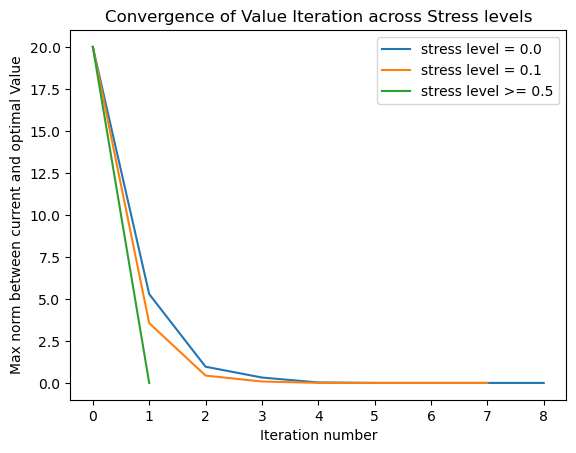

In [12]:
plt.plot(maxnorm1, label="stress level = 0.0")
plt.plot(maxnorm2, label="stress level = 0.1")
plt.plot(maxnorm3, label="stress level >= 0.5")
plt.title("Convergence of Value Iteration across Stress levels")
plt.xlabel("Iteration number")
plt.ylabel("Max norm between current and optimal Value")
plt.legend()
plt.show()


We can see that there is faster convergence for higher stress levels greater than or equal to 0.5, than for lower stress levels closer to 0.

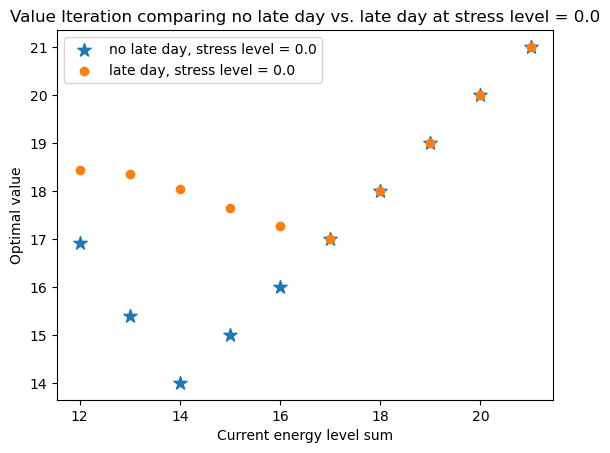

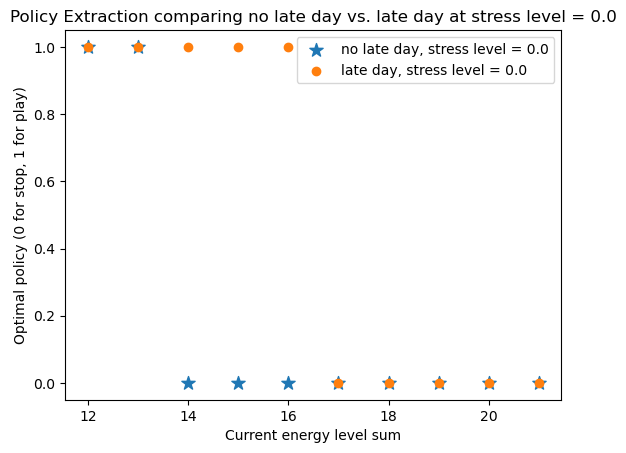

In [13]:
plt.scatter(x, V_1[:10], label="no late day, stress level = 0.0", marker="*", s=100)
plt.scatter(x, V_1[10:], label="late day, stress level = 0.0")
plt.xlabel("Current energy level sum")
plt.ylabel("Optimal value")
plt.title("Value Iteration comparing no late day vs. late day at stress level = 0.0")
plt.legend()
plt.show()

plt.scatter(x, p_1[:10], label="no late day, stress level = 0.0", marker="*", s=100)
plt.scatter(x, p_1[10:], label="late day, stress level = 0.0")
plt.xlabel("Current energy level sum")
plt.ylabel("Optimal policy (0 for stop, 1 for play)")
plt.title("Policy Extraction comparing no late day vs. late day at stress level = 0.0")
plt.legend()
plt.show()

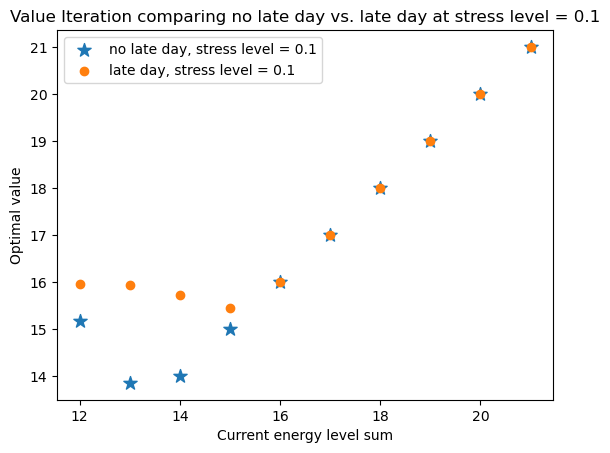

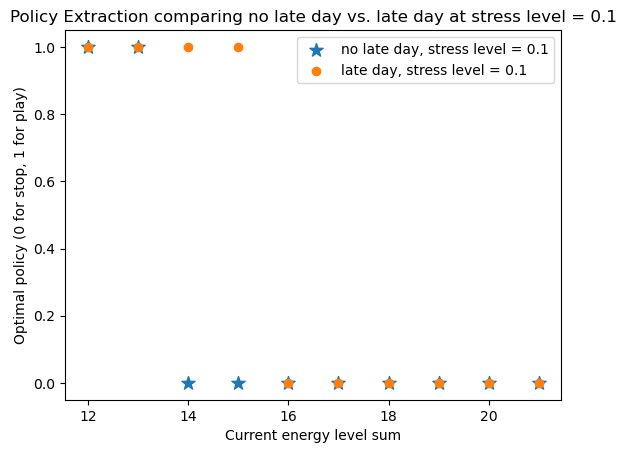

In [14]:
plt.scatter(x, V_2[:10], label="no late day, stress level = 0.1", marker="*", s=100)
plt.scatter(x, V_2[10:], label="late day, stress level = 0.1")
plt.xlabel("Current energy level sum")
plt.ylabel("Optimal value")
plt.title("Value Iteration comparing no late day vs. late day at stress level = 0.1")
plt.legend()
plt.show()

plt.scatter(x, p_2[:10], label="no late day, stress level = 0.1", marker="*", s=100)
plt.scatter(x, p_2[10:], label="late day, stress level = 0.1")
plt.xlabel("Current energy level sum")
plt.ylabel("Optimal policy (0 for stop, 1 for play)")
plt.title("Policy Extraction comparing no late day vs. late day at stress level = 0.1")
plt.legend()
plt.show()

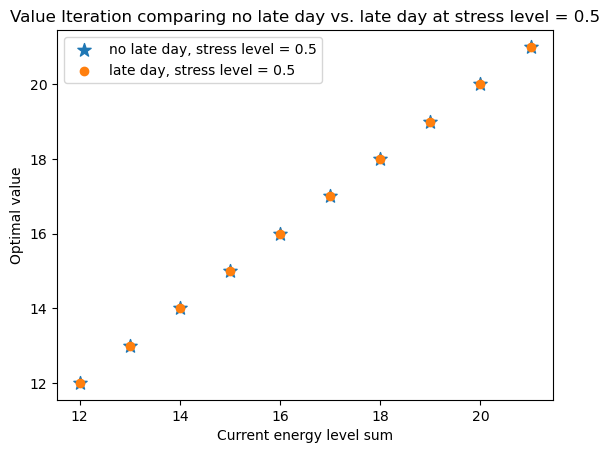

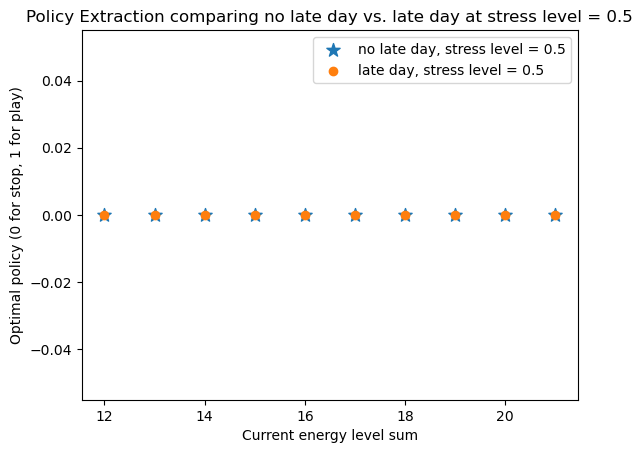

In [15]:
plt.scatter(x, V_3[:10], label="no late day, stress level = 0.5", marker="*", s=100)
plt.scatter(x, V_3[10:], label="late day, stress level = 0.5")
plt.xlabel("Current energy level sum")
plt.ylabel("Optimal value")
plt.title("Value Iteration comparing no late day vs. late day at stress level = 0.5")
plt.legend()
plt.show()

plt.scatter(x, p_3[:10], label="no late day, stress level = 0.5", marker="*", s=100)
plt.scatter(x, p_3[10:], label="late day, stress level = 0.5")
plt.xlabel("Current energy level sum")
plt.ylabel("Optimal policy (0 for stop, 1 for play)")
plt.title("Policy Extraction comparing no late day vs. late day at stress level = 0.5")
plt.legend()
plt.show()

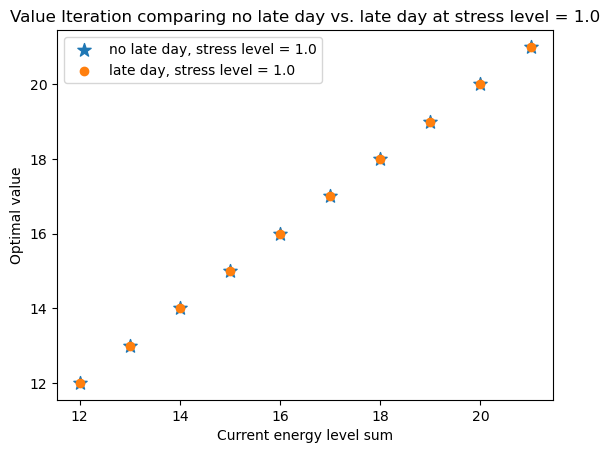

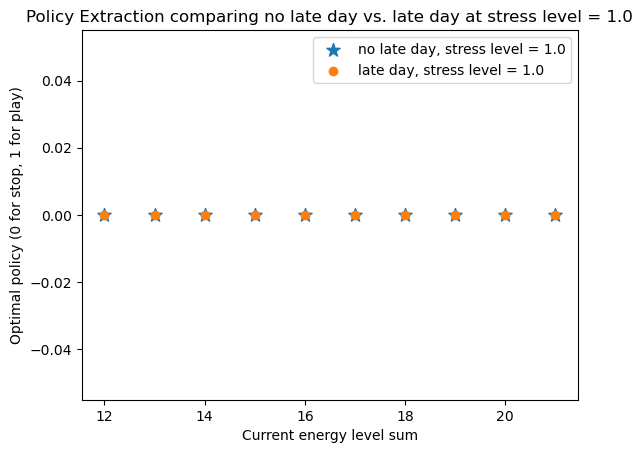

In [16]:
plt.scatter(x, V_4[:10], label="no late day, stress level = 1.0", marker="*", s=100)
plt.scatter(x, V_4[10:], label="late day, stress level = 1.0")
plt.xlabel("Current energy level sum")
plt.ylabel("Optimal value")
plt.title("Value Iteration comparing no late day vs. late day at stress level = 1.0")
plt.legend()
plt.show()

plt.scatter(x, p_4[:10], label="no late day, stress level = 1.0", marker="*", s=100)
plt.scatter(x, p_4[10:], label="late day, stress level = 1.0")
plt.xlabel("Current energy level sum")
plt.ylabel("Optimal policy (0 for stop, 1 for play)")
plt.title("Policy Extraction comparing no late day vs. late day at stress level = 1.0")
plt.legend()
plt.show()

# Some Results
- Based on my plots, the optimal strategy is to **play the next song** until energy level 13 and **stop listening to music** with energy level sums $\geq 14$ in the case of no late day, and low stress levels $\eta = 0, 0.1$. This changes with an increase in stress level $\eta \geq 0.5$ , to make us always **stop listening to music** for all energy levels $\geq 12$ because the college student is sufficiently stressed that they won't finish the assignment by the deadline, and won't have a late day to use.

- For $\eta=0.0$, the optimal actions in states with a usable late day are to **play the next song up until the sum of 16 and stop listening to a music for a sum $\geq 17$** for sums $\geq 12$. For $\eta=1.0$, no useable late day and energy level sums $\geq 12$, the optimal action is **play the next song up until the sum of 13 and stop listening to a music for a sum $\geq 14$** . The reason for the discrepancy in optimal values is because the college student is optimistic under uncertainty when they have a late day (as a kind of a veto power) and wants to play next song in their study break so they can possibly get a higher energy boost in in the future.

- Based on my plots, the optimal actions in states with usable late day (with sums $\geq 12$) are to play the next song upto energy level 16 for $\eta = 0.0$ and stop listening to music for any sum greater than that, play the next song upto energy level 15 for $\eta=0.1$ and stop for any sum greater than that, and stop listening to music for all cumulative energy levels for $\eta=0.5$. **The optimal actions depend on the value of stress level $\eta$, as $\eta$ represents pessimism under uncertainty.** Higher $\eta$ close to 1 penalizes expected future utility highly if the decision made is to play the next song and so we always stop listening to music for $\eta \geq 0.5$, while lower stress levels $\eta$ closer to 0 mean the college student is optimistic under uncertainty and the optimal action is to play the next song. Thus, as $\eta$ decreases we become less stressed and more optimistic under uncertainty and stop at an later cumulative energy level ($\geq 17$ for $\eta = 0.0$, rather than $\geq 16$ for $\eta = 0.1$) as our optimal strategy.